In [ ]:
import sys
import cv2
import numpy as np
from matplotlib import pyplot as plt

def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ration = w/h
    plt.figure(figsize=(aspect_ration* size, size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    plt.title(title)
    plt.show()
    

In [6]:
import os
import math
import scipy.signal
import shutil
import cv2
import numpy as np

def generating_kernel(parameter):
    kernel = np.array([0.25 - parameter/2.0, 0.25, parameter, 0.25, 0.25 - parameter/2.0])
    return np.outer(kernel, kernel)

def reduce_img(image):
    kernel = generating_kernel(0.4)
    
    output = scipy.signal.convolve2d(image, kernel, 'same')
    
    return output[:output.shape[0]:2, :output.shape[1]:2]

def expand(image):
    kernel = generating_kernel(0.4)
    
    output = np.zeros((image.shape[0] * 2, image.shape[1] * 2))
    output[:output.shape[0]:2,  :output.shape[1]:2] = image
    
    output = scipy.signal.convolve2d(output, kernel, 'same') * 4
    return output

def gauss_pyramid(image, levels):
    output = [image]
    for level in range(levels):
        output.append(reduce_img(output[level]))
    
    return output

def lapl_pyramid(gauss_pyr):
    output = []
    for image1, image2 in zip(gauss_pyr[:-1], gauss_pyr[1:]):
        output.append(
            image1 - expand(image2)[:image1.shape[0], :image1.shape[1]])
    output.append(gauss_pyr[-1])
    return output

def blend(lapl_pyr_white, lapl_pyr_black, gauss_pyr_mask):
    blended_pyr = []
    for lapl_white, lapl_black, gauss_mask in zip(lapl_pyr_white, lapl_pyr_black, gauss_pyr_mask):
        blended_pyr.append(gauss_mask*lapl_white + (1 - gauss_mask)*lapl_black)
    return blended_pyr    
    
def collapse(pyramid):
    output = pyramid[-1]
    for image in reversed(pyramid[:-1]):
        output = image + expand(output)[:image.shape[0], :image.shape[1]]
    return output

def run_blend(black_image, white_image, mask):
    min_size = min(black_image.shape)
    
    depth = int(math.floor(math.log(min_size, 2))) - 4
    
    gauss_pyr_mask = gauss_pyramid(mask, depth)
    gauss_pyr_white = gauss_pyramid(white_image, depth)
    gauss_pyr_black = gauss_pyramid(black_image, depth)
    
    lapl_pyr_white = lapl_pyramid(gauss_pyr_white)
    lapl_pyr_black = lapl_pyramid(gauss_pyr_black)
    
    outpyr = blend(lapl_pyr_white, lapl_pyr_black, gauss_pyr_mask)
    
    outimg = collapse(outpyr)
    
    outimg[outimg < 0] = 0
    outimg[outimg > 255]  = 255
    outimg = outimg.astype(np.uint8)
    
    return outimg

def get_images(sourcefolder):
    filenames = os.listdir(sourcefolder)
    for photo in filenames:
        black_img = cv2.imread('D:/images/Original/' + photo)
        white_img = cv2.imread('D:/images/blur/' + photo)
        mask_img = cv2.imread('D:/images/mask/' + photo)
        
        if mask_img is None:
            print('No mask', photo)
            continue
        if white_img is None:
            print('No white image', photo)
            continue
        assert black_img.shape == white_img.shape, \
            "Error - the size of black image and white not the same"
        assert black_img.shape == mask_img.shape, \
            "Error - the size of black image and mask not the same"
    print(photo)
    yield photo, white_img, black_img, mask_img

city.jpg


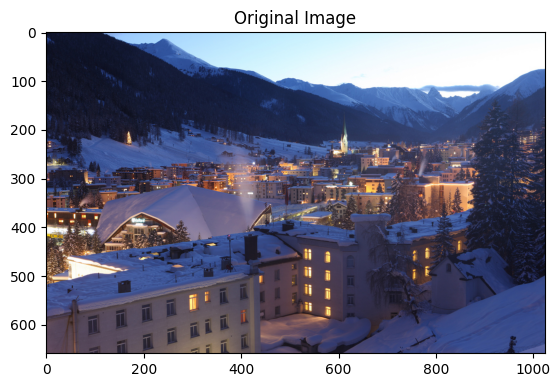

...applying blending


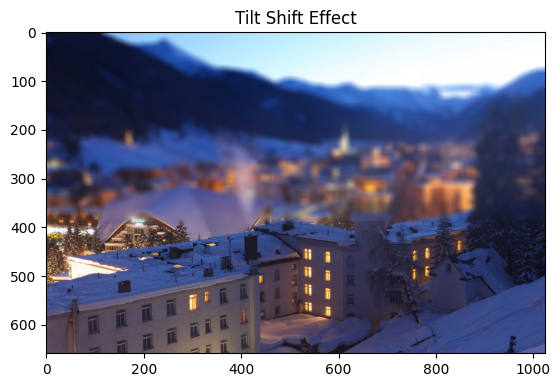

...[DONE]


In [8]:
def main():
    """Given the two images, blend them according to the mask."""

    sourcefolder = 'D:/images/Original'
    outfolder = 'D:/images/output'

    if os.path.isdir(outfolder):
        shutil.rmtree(outfolder)
    os.mkdir(outfolder)

    for photo, white_img, black_img, mask_img in get_images(sourcefolder):
        imshow("Original Image", black_img)
        print("...applying blending")
        black_img = black_img.astype(float)
        white_img = white_img.astype(float)
        mask_img = mask_img.astype(float) / 255

        out_layers = []
        for channel in range(3):
            outimg = run_blend(black_img[:, :, channel],
                               white_img[:, :, channel],
                               mask_img[:, :, channel])
            out_layers.append(outimg)

        outimg = cv2.merge(out_layers)
        cv2.imwrite(os.path.join(outfolder, photo), outimg)
        imshow("Tilt Shift Effect", outimg)
        print('...[DONE]')

if __name__ == "__main__":
    main()